In [1]:
import os 
import random
import numpy as np
import pandas as pd
import importlib as imp
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.simplefilter('ignore')
pd.options.display.max_columns = 100

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## **Artificial Bee Colony**

In [2]:
from utils import tools, visualize, common
bname = 'benchmarks/B/B-n35-k5.vrp'
problem = tools.get_problem(bname)

n_trucks -> 5
optimal -> 955
capacity -> 100
n_locations -> 35
depot_i -> 0
demands -> [0.0, 12.0, 3.0, 2.0, 13.0, 17.0, 12.0, 1.0, 26.0, 13.0, 15.0, 20.0, 20.0, 3.0, 3.0, 12.0, 25.0, 2.0, 15.0, 24.0, 2.0, 7.0, 15.0, 2.0, 13.0, 9.0, 12.0, 26.0, 17.0, 26.0, 9.0, 14.0, 9.0, 25.0, 13.0]


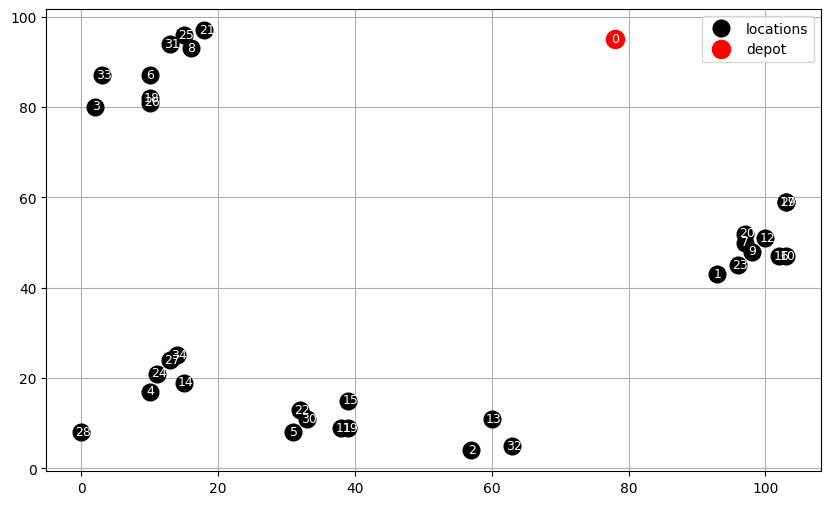

In [3]:
tools     = imp.reload(tools)
visualize = imp.reload(visualize)
common    = imp.reload(common)

visualize.visualize_problem(problem)
for k, v in problem.items():
    if k !='locations' and k !='dists':
        print(k,"->", v)
plt.savefig('output/images/problem'+bname[-10:]+'.png', dpi=400)

In [4]:
common   = imp.reload(common)
solution = common.generate_solution(problem, alpha=0.01, betta=50, verbose=False)
print('Is feasible? {}'.format(common.check_solution(problem, solution, verbose=True)))
sol_cost = common.compute_solution(problem, solution)
print('Solution cost:', sol_cost)
solution

Is feasible? True
Solution cost: 1200.6268


array([ 0, 22, 28, 24,  4, 14,  5, 34,  0, 16, 23,  2, 15, 30, 11, 32, 13,
        0, 33, 26, 21, 25,  3, 18,  6, 31,  0, 12,  1,  9, 20, 29, 10,  7,
       17,  0, 27, 19,  8,  0], dtype=int32)

In [5]:
from algorithm import bee_colony, local_search, neighbor_operator
bee_colony = imp.reload(bee_colony)
local_search = imp.reload(local_search)
neighbor_operator = imp.reload(neighbor_operator)
common = imp.reload(common)

ABC = bee_colony.BeeColony(problem)
ABC.set_params(    
                   n_epoch=200,
                   n_initials=30,
                   n_onlookers=20,
                   search_limit=50
              )
%time abc_solution = ABC.solve(alpha=0.1, delta=0.01, gen_alpha=0.01, gen_betta=25)

  0%|          | 0/200 [00:00<?, ?it/s]

Tries:  16
CPU times: user 20 s, sys: 376 ms, total: 20.3 s
Wall time: 20.2 s


In [6]:
new_cost = common.compute_solution(problem, abc_solution)
print('Is feasible?',common.check_solution(problem, abc_solution, verbose=True))
print('Is capacity?',common.check_capacity_criteria(problem, abc_solution, verbose=False))
print('ABC cost: {}'.format(new_cost))
print('Optimal cost: {}'.format(problem['optimal']))

Is feasible? True
Is capacity? True
ABC cost: 1011.7127075195312
Optimal cost: 955


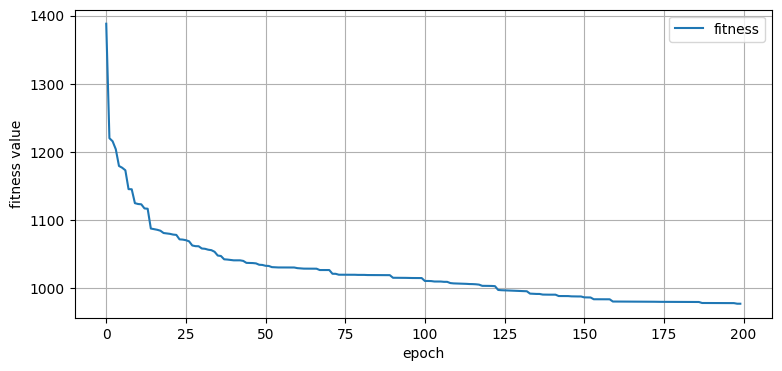

In [7]:
visualize = imp.reload(visualize)
visualize.visualize_fitness(ABC.history)
plt.savefig('output/images/history_'+bname[-10:]+'.png', dpi=400)

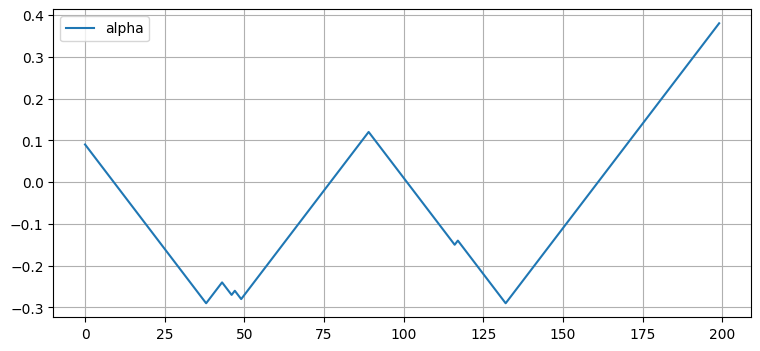

In [8]:
plt.figure(figsize=(9,4))
plt.plot(ABC.history_alpha, label='alpha')
plt.legend()
plt.grid()
plt.show()

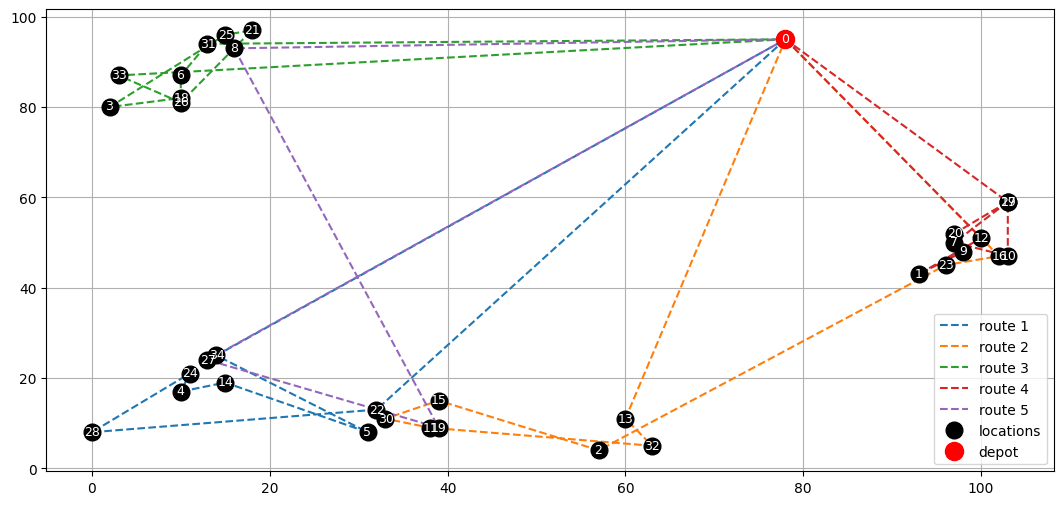

In [9]:
visualize.visualize_problem(problem, solution, figsize=(13,6))
plt.savefig('output/images/beforeABC_'+bname[-10:]+'.png', dpi=400)

Route #1 [15 11 19  2 32 13]
Route #2 [20  7  9 23  1 34 27 26 18]
Route #3 [ 8  6  3 33 31 25 21]
Route #4 [14 24  4 28  5 30 22]
Route #5 [17 29 12 16 10]


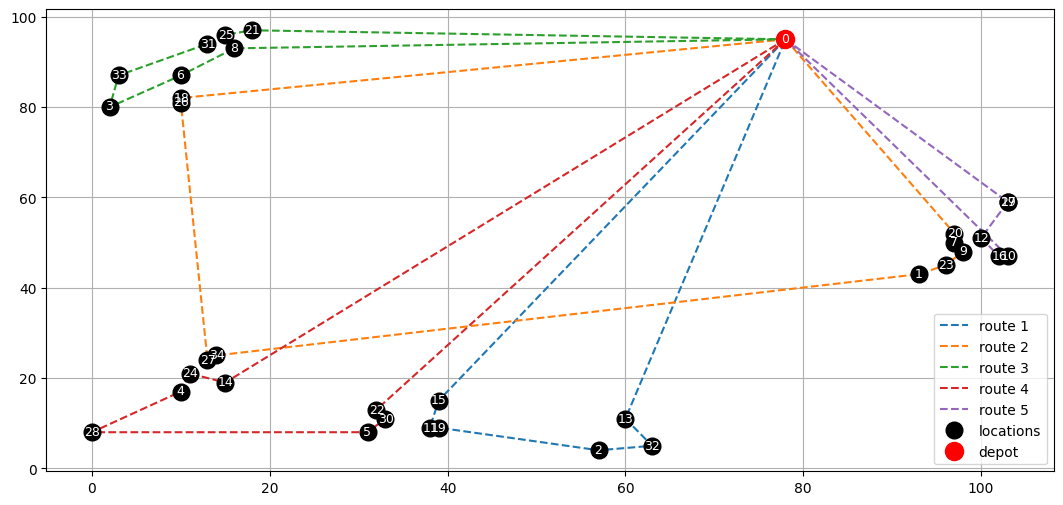

In [10]:
visualize.visualize_problem(problem, abc_solution, figsize=(13,6))
depots = list(filter(lambda i: abc_solution[i]==0, range(len(abc_solution))))
for i, route in  enumerate(common.get_routes(abc_solution)):
    print('Route #{}'.format(i+1),route)
# len(abc_solution), len(np.unique(abc_solution))
plt.savefig('output/images/afterABC_'+bname[-10:]+'.png', dpi=400)

In [11]:
%%time
import glob
from datetime import datetime
tools     = imp.reload(tools)
bee_colony = imp.reload(bee_colony)
local_search = imp.reload(local_search)
common = imp.reload(common)
neighbor_operator = imp.reload(neighbor_operator)



b_benchmarks = glob.glob('benchmarks/B/*')

info_dct = dict(benchmark=[],
                n_locations=[],
                n_trucks=[],
                capacity=[],
                optimal_cost=[],
                ABC_cost=[],
                ABC_time=[],
                is_feasible=[],
                error=[],
                abc_solution=[],
                abc_epochs=[],
                abc_employers=[],
                abc_onlookers=[],
                abc_search_limit=[])

for itr, benchmark in enumerate(b_benchmarks[:]):
    
    problem = tools.get_problem(benchmark)
    bench_name = benchmark[benchmark.index("/")+1:]
   # try:
    #    bench_name = benchmark[benchmark.index("/") + 1:]
    #except ValueError:
    # Handle the case where the backslash is not found, e.g., by setting a default value or another action
     #   bench_name = benchmark  # or some default value or action

    
    print('#{}'.format(itr), bench_name,'...')

    ABC = bee_colony.BeeColony(problem)
    ABC.set_params(    
                       n_epoch=300,
                       n_initials=problem['n_locations'],
                       n_onlookers=5,
                       search_limit=problem['n_locations']
                  )
    start_time = datetime.now()
    alpha = problem['n_locations'] / 100
    delta = 0.01
    gen_alpha = 0.5
    gen_betta = problem['n_locations']
    abc_solution = ABC.solve(alpha=alpha, delta=delta, gen_betta=gen_betta)
    end_time = (datetime.now() - start_time).total_seconds()
    
    abc_cost = common.compute_solution(problem, abc_solution)
    is_feasible = common.check_solution(problem, abc_solution, verbose=True)
    error = (abc_cost - problem['optimal']) / problem['optimal']
    print('epoch:',ABC.n_epoch, 'initials:', ABC.n_initials,'search_limit:', ABC.search_limit)
    

    info_dct['benchmark']    += [bench_name]
    info_dct['n_locations']  += [problem['n_locations']]
    info_dct['n_trucks']     += [problem['n_trucks']]
    info_dct['capacity']     += [problem['capacity']]
    info_dct['optimal_cost'] += [problem['optimal']]
    info_dct['ABC_cost']      += [abc_cost]
    info_dct['ABC_time']      += [end_time]
    info_dct['is_feasible']   += [is_feasible]
    info_dct['error']         += [error]
    info_dct['abc_solution']  += [abc_solution]
    info_dct['abc_epochs']    += [ABC.n_epoch]
    info_dct['abc_employers'] += [ABC.n_initials]
    info_dct['abc_onlookers'] += [ABC.n_onlookers]
    info_dct['abc_search_limit'] += [ABC.search_limit]
    
    print(alpha, delta, gen_betta)
    if not is_feasible:
        print('Does not feasible...')
        break
    
    tools.write_solution(abc_solution, abc_cost, filename='/'+bench_name[:-4]+'.sol')

#0 B/B-n34-k5.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  21
epoch: 300 initials: 34 search_limit: 34
0.34 0.01 34
#1 B/B-n45-k5.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  16
epoch: 300 initials: 45 search_limit: 45
0.45 0.01 45
#2 B/B-n64-k9.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  4
epoch: 300 initials: 64 search_limit: 64
0.64 0.01 64
#3 B/B-n68-k9.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  27
epoch: 300 initials: 68 search_limit: 68
0.68 0.01 68
#4 B/B-n38-k6.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  18
epoch: 300 initials: 38 search_limit: 38
0.38 0.01 38
#5 B/B-n45-k6.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  13
epoch: 300 initials: 45 search_limit: 45
0.45 0.01 45
#6 B/B-n57-k7.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  18
epoch: 300 initials: 57 search_limit: 57
0.57 0.01 57
#7 B/B-n67-k10.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  17
epoch: 300 initials: 67 search_limit: 67
0.67 0.01 67
#8 B/B-n66-k9.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  24
epoch: 300 initials: 66 search_limit: 66
0.66 0.01 66
#9 B/B-n50-k8.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  28
epoch: 300 initials: 50 search_limit: 50
0.5 0.01 50
#10 B/B-n51-k7.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  26
epoch: 300 initials: 51 search_limit: 51
0.51 0.01 51
#11 B/B-n43-k6.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  15
epoch: 300 initials: 43 search_limit: 43
0.43 0.01 43
#12 B/B-n41-k6.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  30
epoch: 300 initials: 41 search_limit: 41
0.41 0.01 41
#13 B/B-n44-k7.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  10
epoch: 300 initials: 44 search_limit: 44
0.44 0.01 44
#14 B/B-n56-k7.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  29
epoch: 300 initials: 56 search_limit: 56
0.56 0.01 56
#15 B/B-n35-k5.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  24
epoch: 300 initials: 35 search_limit: 35
0.35 0.01 35
#16 B/B-n78-k10.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  21
epoch: 300 initials: 78 search_limit: 78
0.78 0.01 78
#17 B/B-n39-k5.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  20
epoch: 300 initials: 39 search_limit: 39
0.39 0.01 39
#18 B/B-n50-k7.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  19
epoch: 300 initials: 50 search_limit: 50
0.5 0.01 50
#19 B/B-n52-k7.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  28
epoch: 300 initials: 52 search_limit: 52
0.52 0.01 52
#20 B/B-n63-k10.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  14
epoch: 300 initials: 63 search_limit: 63
0.63 0.01 63
#21 B/B-n57-k9.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  33
epoch: 300 initials: 57 search_limit: 57
0.57 0.01 57
#22 B/B-n31-k5.vrp ...


  0%|          | 0/300 [00:00<?, ?it/s]

Tries:  0
epoch: 300 initials: 31 search_limit: 31
0.31 0.01 31
CPU times: user 14min 36s, sys: 7.99 s, total: 14min 44s
Wall time: 14min 40s


In [12]:
b_stat = pd.DataFrame.from_dict(info_dct)
columns = ['benchmark', 'n_locations', 'n_trucks', 'capacity', 'optimal_cost', 'ABC_cost', 'ABC_time', 'error', 'is_feasible']
print(b_stat[columns].to_markdown())

|    | benchmark       |   n_locations |   n_trucks |   capacity |   optimal_cost |   ABC_cost |   ABC_time |     error | is_feasible   |
|---:|:----------------|--------------:|-----------:|-----------:|---------------:|-----------:|-----------:|----------:|:--------------|
|  0 | B/B-n34-k5.vrp  |            34 |          5 |        100 |            788 |    803.621 |    17.8361 | 0.0198232 | True          |
|  1 | B/B-n45-k5.vrp  |            45 |          5 |        100 |            751 |    817.623 |    26.1382 | 0.0887121 | True          |
|  2 | B/B-n64-k9.vrp  |            64 |          9 |        100 |            861 |   1075.56  |    55.3815 | 0.249195  | True          |
|  3 | B/B-n68-k9.vrp  |            68 |          9 |        100 |           1272 |   1519.24  |    60.7085 | 0.194371  | True          |
|  4 | B/B-n38-k6.vrp  |            38 |          6 |        100 |            805 |    835.673 |    22.3303 | 0.0381032 | True          |
|  5 | B/B-n45-k6.vrp  |          

## **Ant Colony Optimization**

In [13]:
import numpy as np
import random

In [14]:
# Function to parse the VRP dataset
# Replace 'your_dataset_path.vrp' with the actual path to your dataset file
file_path = 'benchmarks/B/B-n31-k5.vrp'  # Example: '/path/to/your/dataset/B-n31-k5.vrp'

def parse_vrp_dataset(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    coordinates = {}
    demands = {}
    capacity = 0
    section = None

    for line in lines:
        if "DIMENSION" in line:
            dimension = int(line.split(":")[1])
        elif "CAPACITY" in line:
            capacity = int(line.split(":")[1])
        elif "NODE_COORD_SECTION" in line:
            section = "coordinates"
            continue
        elif "DEMAND_SECTION" in line:
            section = "demands"
            continue
        elif "DEPOT_SECTION" in line:
            break  # Assuming we don't need depot specific info beyond this

        if section == "coordinates" and line.strip():
            parts = line.strip().split()
            coordinates[int(parts[0])] = (float(parts[1]), float(parts[2]))
        elif section == "demands" and line.strip():
            parts = line.strip().split()
            demands[int(parts[0])] = int(parts[1])

    return coordinates, demands, capacity

coordinates, demands, vehicle_capacity = parse_vrp_dataset(file_path)


# Now, you can use 'coordinates', 'demands', and 'vehicle_capacity' in your ACO implementation
# Example: calculating the distance matrix, initializing ants, etc., as shown in the previous code block.

# Your ACO implementation code here...


In [15]:
# Helper function to calculate Euclidean distance
def euclidean_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

In [16]:
# Function to calculate distance matrix between all locations
def calculate_distance_matrix(coordinates):
    n = len(coordinates)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distances[i, j] = euclidean_distance(coordinates[i+1], coordinates[j+1])
    return distances

In [17]:
# ACO parameters
num_ants = 10
num_iterations = 100
alpha = 1.0  # Influence of pheromone
beta = 5.0  # Influence of heuristic information (distance)
evaporation_rate = 0.5
pheromone_deposit = 1.0
capacity = 100  # Vehicle capacity from the dataset

# Initialization
distances = calculate_distance_matrix(coordinates)
pheromones = np.ones(distances.shape) / len(coordinates)
demand_list = np.array(list(demands.values()))

In [18]:
# Function to select the next node based on ACO transition rule
def select_next_node(current_node, taboo_list, demands, vehicle_capacity):
    probabilities = np.zeros(len(distances))
    for i in range(len(distances)):
        if i not in taboo_list and demands[i] <= vehicle_capacity:
            try:
                probabilities[i] = pheromones[current_node][i]**alpha * (1.0 / distances[current_node][i])**beta
            except ZeroDivisionError:
                pass
    probabilities /= probabilities.sum()
    return np.random.choice(np.arange(len(distances)), p=probabilities)

In [19]:
def aco_main_loop(num_ants, num_iterations, distances, demands, vehicle_capacity, alpha, beta, evaporation_rate, pheromone_deposit,pheromones):
    best_route = None
    best_route_length = float('inf')
    
    for iteration in range(num_iterations):
        routes = []
        route_lengths = []
        
        for ant in range(num_ants):
            # Initialize ant
            route = [0]  # Starting at the depot
            remaining_capacity = vehicle_capacity
            remaining_nodes = set(range(1, len(distances)))  # Excluding the depot initially
            
            while remaining_nodes:
                current_node = route[-1]
                if remaining_capacity < min([demands[n] for n in remaining_nodes]):
                    # Return to depot if the remaining capacity is less than the demands of all remaining nodes
                    route.append(0)
                    remaining_capacity = vehicle_capacity
                    continue
                
                probabilities = []
                for next_node in remaining_nodes:
                    if demands[next_node] <= remaining_capacity:
                        tau = pheromones[current_node][next_node] ** alpha
                        eta = (1.0 / distances[current_node][next_node]) ** beta
                        probabilities.append(tau * eta)
                    else:
                        probabilities.append(0)
                
                probabilities = np.array(probabilities) / sum(probabilities)
                next_node = random.choices(list(remaining_nodes), weights=probabilities, k=1)[0]
                
                route.append(next_node)
                remaining_nodes.remove(next_node)
                remaining_capacity -= demands[next_node]
                # Return to depot to offload if needed
            if remaining_capacity == 0:
                    route.append(0)
                    remaining_capacity = vehicle_capacity
                    # Complete the route by returning to the depot
            if route[-1] != 0:
                route.append(0)
                # Calculate the length of the route
            route_length = sum(distances[route[i]][route[i+1]] for i in range(len(route)-1))
            routes.append(route)
            route_lengths.append(route_length)
            # Update best route
        min_route_length = min(route_lengths)
        if min_route_length < best_route_length:
            best_route_length = min_route_length
            best_route = routes[route_lengths.index(min_route_length)]
            # Update pheromones
        pheromones *= (1 - evaporation_rate)  # Evaporation
        for route, length in zip(routes, route_lengths):
            deposit_amount = pheromone_deposit / length
            for i in range(len(route)-1):
                pheromones[route[i]][route[i+1]] += deposit_amount
        
        # Optionally, add extra pheromone on the global best route
        # for i in range(len(best_route)-1):
        #     pheromones[best_route[i]][best_route[i+1]] += extra_deposit
        
    return best_route, best_route_length


In [20]:
# You would call this function with the ACO parameters and the parsed data from your VRP dataset
best_route, best_route_length = aco_main_loop(
    num_ants=num_ants, 
    num_iterations=num_iterations, 
    distances=distances, 
    demands=demand_list, 
    vehicle_capacity=capacity, 
    alpha=alpha, 
    beta=beta, 
    evaporation_rate=evaporation_rate, 
    pheromone_deposit=pheromone_deposit,
    pheromones=pheromones  # Include this line to pass the pheromone matrix
)

In [21]:
print("Best Route:", best_route)
print("Best Route Length:", best_route_length)

Best Route: [0, 22, 9, 6, 17, 30, 29, 8, 0, 26, 28, 12, 23, 7, 25, 21, 0, 27, 10, 20, 2, 14, 11, 19, 24, 15, 0, 1, 3, 13, 4, 5, 0, 18, 16, 0]
Best Route Length: 740.5162327316435


In [22]:
import os
import glob

# Assuming 'parse_vrp_dataset' and 'aco_main_loop' are defined functions
# from previous discussions.

# Directory where your VRP files are stored
dataset_directory = '/Users/rishithareddyavuku/Downloads/VehicleRoutingProblem-master/benchmarks/B'

# Find all VRP files
vrp_files = glob.glob(os.path.join(dataset_directory, '*.vrp'))

# Dictionary to store the best route length for each file
best_route_lengths = {}

for vrp_file in vrp_files:
    # Parse the VRP file
    coordinates, demands, vehicle_capacity = parse_vrp_dataset(vrp_file)
    
    # Initialize distances and pheromones, assuming you have functions or code for this
    distances = calculate_distance_matrix(coordinates)
    pheromones = np.ones(distances.shape) / len(coordinates)
    
    # Solve the VRP instance using ACO
    best_route, best_route_length = aco_main_loop(
        num_ants=10,  # You may adjust these parameters as needed
        num_iterations=100,
        distances=distances,
        demands=np.array(list(demands.values())),
        vehicle_capacity=vehicle_capacity,
        alpha=1.0,
        beta=5.0,
        evaporation_rate=0.5,
        pheromone_deposit=1.0,
        pheromones=pheromones
    )
    
    # Store or print the result
    best_route_lengths[os.path.basename(vrp_file)] = best_route_length

# Print all results
for vrp_file, length in best_route_lengths.items():
    print(f"{vrp_file}: Best Route Length = {length}")


B-n34-k5.vrp: Best Route Length = 819.9554767204028
B-n45-k5.vrp: Best Route Length = 937.7682823586274
B-n64-k9.vrp: Best Route Length = 1144.9155717403853
B-n68-k9.vrp: Best Route Length = 1582.3281942825436
B-n38-k6.vrp: Best Route Length = 892.2471280024374
B-n45-k6.vrp: Best Route Length = 834.036129712504
B-n57-k7.vrp: Best Route Length = 1641.918145060989
B-n67-k10.vrp: Best Route Length = 1425.614134647477
B-n66-k9.vrp: Best Route Length = 1551.8469499404512
B-n50-k8.vrp: Best Route Length = 1478.6858947223636
B-n51-k7.vrp: Best Route Length = 1164.2566853549592
B-n43-k6.vrp: Best Route Length = 912.2269894149648
B-n41-k6.vrp: Best Route Length = 912.8159098906475
B-n44-k7.vrp: Best Route Length = 1102.9199159230516
B-n56-k7.vrp: Best Route Length = 1082.552859941633
B-n35-k5.vrp: Best Route Length = 1097.618534401263
B-n78-k10.vrp: Best Route Length = 1469.410860567604
B-n39-k5.vrp: Best Route Length = 763.9726199054695
B-n50-k7.vrp: Best Route Length = 921.5625516667877
B-n52

In [23]:
import os
import glob
import pandas as pd
import numpy as np

# Adjusting the parse_vrp_dataset function to also return the optimal cost
def parse_vrp_dataset_with_optimal_cost(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    coordinates = {}
    demands = {}
    capacity = 0
    optimal_cost = None  # Initialize optimal cost
    section = None

    for line in lines:
        if "DIMENSION" in line:
            dimension = int(line.split(":")[1])
        elif "CAPACITY" in line:
            capacity = int(line.split(":")[1])
        # Inside your parse_vrp_dataset_with_optimal_cost function
        elif "COMMENT" in line and "Optimal value:" in line:
    # Extracting the optimal cost, ensuring we remove non-numeric characters like parentheses
            optimal_cost_str = line.split("Optimal value:")[-1].split()[0]  # This gets the value as a string
            optimal_cost = float(''.join(filter(str.isdigit, optimal_cost_str)))  # Converts to float, removing non-digits

        elif "NODE_COORD_SECTION" in line:
            section = "coordinates"
            continue
        elif "DEMAND_SECTION" in line:
            section = "demands"
            continue
        elif "DEPOT_SECTION" in line:
            break

        if section == "coordinates" and line.strip():
            parts = line.strip().split()
            coordinates[int(parts[0])] = (float(parts[1]), float(parts[2]))
        elif section == "demands" and line.strip():
            parts = line.strip().split()
            demands[int(parts[0])] = int(parts[1])

    return coordinates, demands, capacity, optimal_cost

# Directory where your VRP files are stored
dataset_directory = '/Users/rishithareddyavuku/Downloads/VehicleRoutingProblem-master/benchmarks/B'

# Find all VRP files
vrp_files = glob.glob(os.path.join(dataset_directory, '*.vrp'))

# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['File Name', 'Optimal Cost', 'Error Rate (%)'])

for vrp_file in vrp_files:
    # Parse the VRP file including optimal cost
    coordinates, demands, vehicle_capacity, optimal_cost = parse_vrp_dataset_with_optimal_cost(vrp_file)
    
    # Your ACO algorithm here to find best_route and best_route_length...
    
    # Calculate error rate
    error_rate = ((best_route_length - optimal_cost) / optimal_cost) * 100 if optimal_cost else None
    
    # Append results to the DataFrame
    results_df = results_df.append({
        'File Name': os.path.basename(vrp_file),
        'Optimal Cost': optimal_cost,
        'Error Rate (%)': error_rate
    }, ignore_index=True)
    
# Display the results in a tabular format
#print(results_df)


In [24]:
import os
import glob
import pandas as pd
import numpy as np

# Assume 'parse_vrp_dataset_with_optimal_cost' and 'aco_main_loop' are defined as shown above.

# Initialize a DataFrame to store results, now including 'Best Route Length'
results_df = pd.DataFrame(columns=['File Name', 'Best Route Length', 'Optimal Cost', 'Error Rate (%)'])

for vrp_file in vrp_files:
    # Parse the VRP file including optimal cost
    coordinates, demands, vehicle_capacity, optimal_cost = parse_vrp_dataset_with_optimal_cost(vrp_file)
    
    # Calculate distances and initialize pheromones
    distances = calculate_distance_matrix(coordinates)
    pheromones = np.ones(distances.shape) / len(coordinates)
    
    # Solve the VRP instance using ACO to find best_route and best_route_length
    best_route, best_route_length = aco_main_loop(
        num_ants=10,
        num_iterations=100,
        distances=distances,
        demands=np.array(list(demands.values())),
        vehicle_capacity=vehicle_capacity,
        alpha=1.0,
        beta=5.0,
        evaporation_rate=0.5,
        pheromone_deposit=1.0,
        pheromones=pheromones
    )
    
    # Calculate error rate if optimal cost is available
    error_rate = ((best_route_length - optimal_cost) / optimal_cost) * 100 if optimal_cost is not None else None
    
    # Append results to the DataFrame
    results_df = results_df.append({
        'File Name': os.path.basename(vrp_file),
        'Best Route Length': best_route_length,
        'Optimal Cost': optimal_cost,
        'Error Rate (%)': error_rate
    }, ignore_index=True)
    
# Display the results in a tabular format
print(results_df)


        File Name  Best Route Length  Optimal Cost  Error Rate (%)
0    B-n34-k5.vrp         752.546337         788.0       -4.499196
1    B-n45-k5.vrp         908.868888         751.0       21.021157
2    B-n64-k9.vrp        1224.614482         861.0       42.231647
3    B-n68-k9.vrp        1547.976547        1272.0       21.696269
4    B-n38-k6.vrp         952.031531         805.0       18.264787
5    B-n45-k6.vrp         821.783792         678.0       21.207049
6    B-n57-k7.vrp        1591.840628        1153.0       38.060766
7   B-n67-k10.vrp        1372.967046        1032.0       33.039442
8    B-n66-k9.vrp        1452.571069        1316.0       10.377741
9    B-n50-k8.vrp        1488.065583        1312.0       13.419633
10   B-n51-k7.vrp        1148.557230        1032.0       11.294305
11   B-n43-k6.vrp         874.211531         742.0       17.818266
12   B-n41-k6.vrp         913.735220         829.0       10.221378
13   B-n44-k7.vrp        1100.492348         909.0       21.06

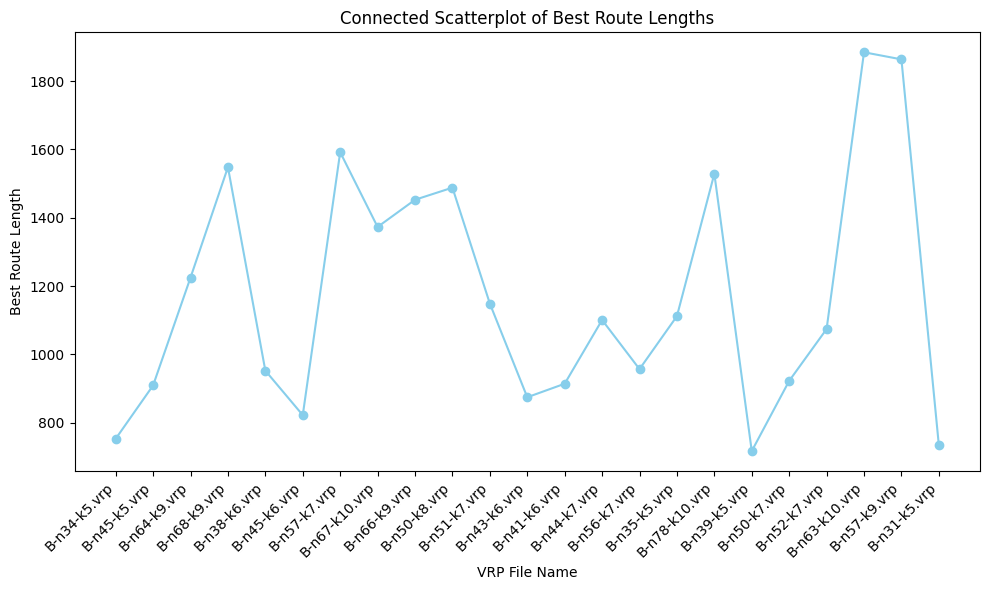

In [25]:
import matplotlib.pyplot as plt

# Optionally, sort the DataFrame by some column if the order of points matters
# results_df.sort_values('SomeColumn', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(results_df['File Name'], results_df['Best Route Length'], '-o', color='skyblue')  # '-o' creates lines and points

plt.xlabel('VRP File Name')
plt.ylabel('Best Route Length')
plt.xticks(rotation=45, ha="right")  # Rotate file names for better readability
plt.title('Connected Scatterplot of Best Route Lengths')
plt.tight_layout()  # Adjust layout

plt.show()


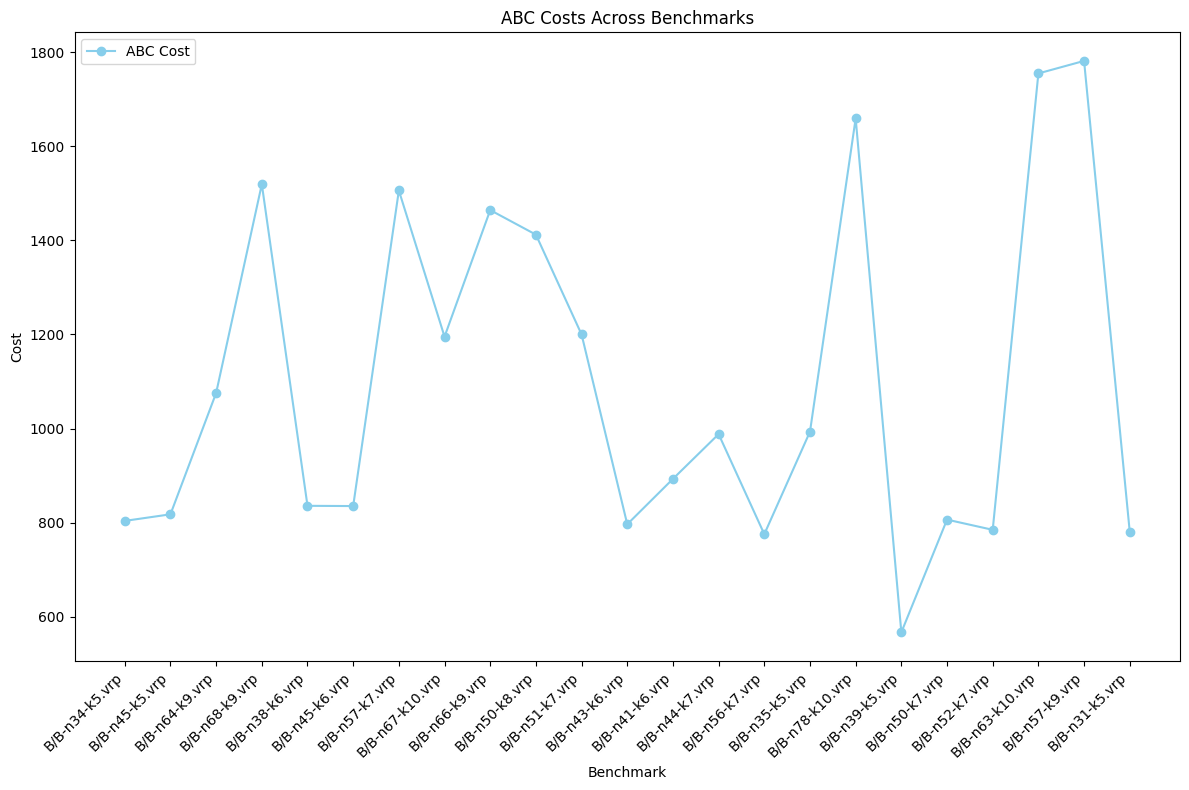

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming info_dct is defined and contains your data
b_stat = pd.DataFrame.from_dict(info_dct)

# Assuming you have columns defined as shown earlier
columns = ['benchmark', 'n_locations', 'n_trucks', 'capacity', 'optimal_cost', 'ABC_cost', 'ABC_time', 'error', 'is_feasible']

# Now, try plotting again
plt.figure(figsize=(12, 8))
plt.plot(b_stat['benchmark'], b_stat['ABC_cost'], '-o', label='ABC Cost', color='skyblue')
plt.xlabel('Benchmark')
plt.ylabel('Cost')
plt.xticks(rotation=45, ha="right")
plt.title('ABC Costs Across Benchmarks')
plt.legend()
plt.tight_layout()
plt.show()


## **Particle Swarm Optimization**

In [27]:
import os
import numpy as np
from scipy.spatial.distance import euclidean

# Function to load a CVRP dataset from a given path
def load_cvrp_dataset(path):
    node_coords = {}
    demands = {}
    capacity = 0
    with open(path, 'r') as file:
        lines = file.readlines()
        section = None
        for line in lines:
            if line.startswith("DIMENSION"):
                dimension = int(line.split(":")[1])
            elif line.startswith("CAPACITY"):
                capacity = int(line.split(":")[1])
            elif line.startswith("NODE_COORD_SECTION"):
                section = "coords"
            elif line.startswith("DEMAND_SECTION"):
                section = "demands"
            elif line.startswith("DEPOT_SECTION"):
                break  # Assuming depot is always the first node and no need to read further
            elif section == "coords":
                parts = line.split()
                node_coords[int(parts[0])] = (float(parts[1]), float(parts[2]))
            elif section == "demands":
                parts = line.split()
                demands[int(parts[0])] = int(parts[1])
    return node_coords, demands, capacity

# Helper function to calculate Euclidean distance
def calculate_distance(node1, node2, node_coords):
    return euclidean(node_coords[node1], node_coords[node2])

# Function to implement the Nearest Neighbor Heuristic for initializing routes
def nearest_neighbor_init(node_coords, demands, vehicle_capacity, num_vehicles=5):
    depot = 1  # Assuming the depot's node ID is always 1
    routes = [[] for _ in range(num_vehicles)]
    current_loads = [0] * num_vehicles
    unvisited_customers = set(node_coords.keys()) - {depot}

    for vehicle in range(num_vehicles):
        current_node = depot
        while unvisited_customers and current_loads[vehicle] < vehicle_capacity:
            distances = {customer: calculate_distance(current_node, customer, node_coords) for customer in unvisited_customers}
            nearest_neighbor = min(distances, key=distances.get)
            if current_loads[vehicle] + demands[nearest_neighbor] <= vehicle_capacity:
                routes[vehicle].append(nearest_neighbor)
                current_loads[vehicle] += demands[nearest_neighbor]
                unvisited_customers.remove(nearest_neighbor)
                current_node = nearest_neighbor
            else:
                break

    return routes, current_loads

# Directory containing the dataset files
dataset_directory = '/Users/rishithareddyavuku/Downloads/VehicleRoutingProblem-master/benchmarks/B'

# List all dataset files in the directory
dataset_files = [os.path.join(dataset_directory, f) for f in os.listdir(dataset_directory) if os.path.isfile(os.path.join(dataset_directory, f))]

# Process each dataset
for dataset_path in dataset_files:
    print(f"Processing {dataset_path}")
    node_coords, demands, vehicle_capacity = load_cvrp_dataset(dataset_path)
    routes, loads = nearest_neighbor_init(node_coords, demands, vehicle_capacity)
    # Output the results
    for i, route in enumerate(routes):
        print(f"Vehicle {i+1}: Route = {route}, Load = {loads[i]}")
    print("\n")


Processing /Users/rishithareddyavuku/Downloads/VehicleRoutingProblem-master/benchmarks/B/B-n34-k5.vrp
Vehicle 1: Route = [6, 7, 26, 18, 32, 16, 29, 14, 20], Load = 100
Vehicle 2: Route = [12, 31, 3, 8, 22, 5, 21], Load = 91
Vehicle 3: Route = [2, 19, 17, 10], Load = 95
Vehicle 4: Route = [13, 27, 9, 34], Load = 91
Vehicle 5: Route = [28, 30, 4, 25, 15, 11, 24, 33, 23], Load = 80


Processing /Users/rishithareddyavuku/Downloads/VehicleRoutingProblem-master/benchmarks/B/B-n45-k5.vrp
Vehicle 1: Route = [40, 31, 24, 18, 11, 37, 2], Load = 81
Vehicle 2: Route = [6, 42, 44, 23, 7, 13, 9, 22, 5, 17], Load = 96
Vehicle 3: Route = [29, 43, 41, 30, 12, 26, 27, 20, 34, 21, 36, 39], Load = 100
Vehicle 4: Route = [10, 14, 16, 33, 38], Load = 84
Vehicle 5: Route = [19, 45, 15, 28, 35, 8, 3, 25], Load = 99


Processing /Users/rishithareddyavuku/Downloads/VehicleRoutingProblem-master/benchmarks/B/B-n64-k9.vrp
Vehicle 1: Route = [8, 31, 47, 42, 55, 9, 22, 28, 39], Load = 93
Vehicle 2: Route = [18, 32, 

In [28]:
def calculate_total_distance(route, node_coords):
    total_distance = 0.0
    if not route:
        return total_distance
    # Add distance from depot to the first customer
    depot_position = node_coords[1]  # Assuming the depot's ID is always 1
    first_customer_position = node_coords[route[0]]
    total_distance += euclidean(depot_position, first_customer_position)
    # Sum distances between consecutive customers
    for i in range(len(route) - 1):
        distance = euclidean(node_coords[route[i]], node_coords[route[i + 1]])
        total_distance += distance
    # Add distance from the last customer back to the depot
    last_customer_position = node_coords[route[-1]]
    total_distance += euclidean(last_customer_position, depot_position)
    return total_distance


In [29]:
from math import sqrt

def euclidean(point1, point2):
    return sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)))


In [30]:
import pandas as pd

# Assuming you have a function to calculate total route distance
# def calculate_total_distance(route, node_coords): ...

lowest_distances = []

for dataset_path in dataset_files:
    node_coords, demands, vehicle_capacity = load_cvrp_dataset(dataset_path)
    routes, loads = nearest_neighbor_init(node_coords, demands, vehicle_capacity)
    
    # Calculate and find the lowest distance among routes
    lowest_distance = float('inf')
    for route in routes:
        total_distance = calculate_total_distance(route, node_coords)  # You need to implement this
        if total_distance < lowest_distance:
            lowest_distance = total_distance
    
    lowest_distances.append({
        "Dataset": os.path.basename(dataset_path),
        "Lowest Route Distance": lowest_distance
    })

# Convert the results into a DataFrame for nicer display
results_df = pd.DataFrame(lowest_distances)

# Display the table
print(results_df)


          Dataset  Lowest Route Distance
0    B-n34-k5.vrp             144.242091
1    B-n45-k5.vrp              56.524256
2    B-n64-k9.vrp              56.615493
3    B-n68-k9.vrp              63.110265
4    B-n38-k6.vrp              77.335116
5    B-n45-k6.vrp              55.369275
6    B-n57-k7.vrp             140.087222
7   B-n67-k10.vrp              42.399983
8    B-n66-k9.vrp              54.411707
9    B-n50-k8.vrp             101.430416
10   B-n51-k7.vrp             103.395813
11   B-n43-k6.vrp              83.540966
12   B-n41-k6.vrp              88.783841
13   B-n44-k7.vrp              62.638007
14   B-n56-k7.vrp              38.693429
15   B-n35-k5.vrp             122.989940
16  B-n78-k10.vrp              29.722524
17   B-n39-k5.vrp              63.636518
18   B-n50-k7.vrp              67.762417
19   B-n52-k7.vrp              55.095749
20  B-n63-k10.vrp              37.839499
21   B-n57-k9.vrp             124.886040
22   B-n31-k5.vrp             102.999915


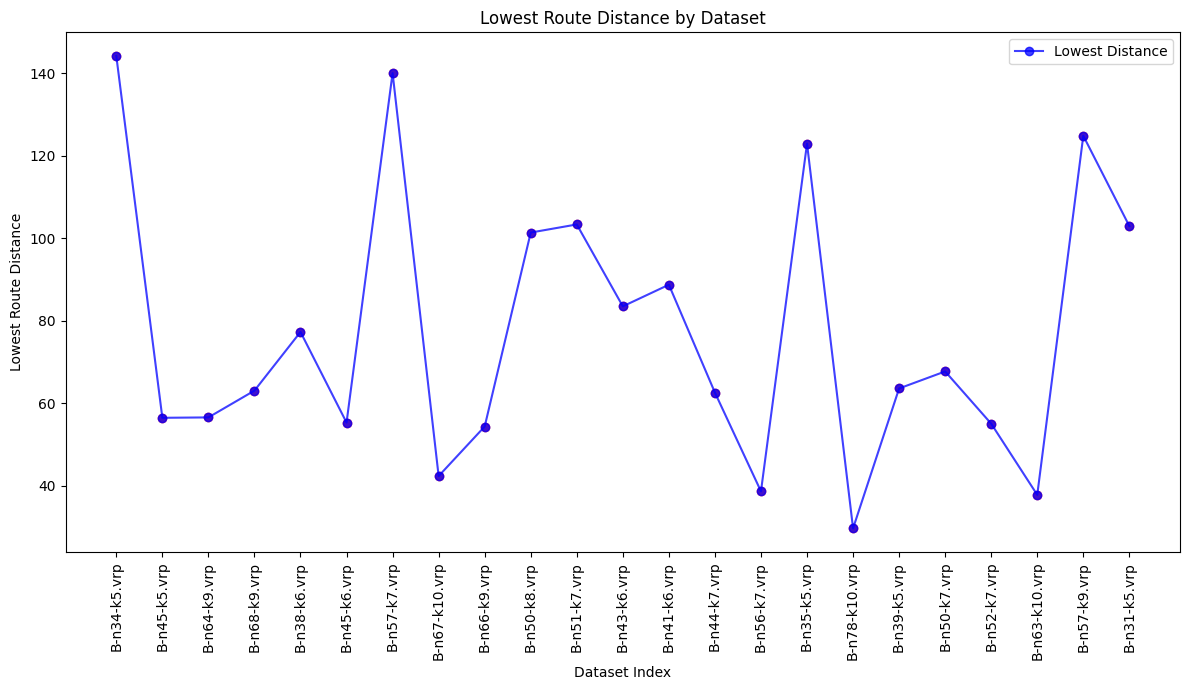

In [31]:
import matplotlib.pyplot as plt

# Convert dataset names to a numerical index for plotting
dataset_indices = range(len(results_df))

# Use the 'Lowest Route Distance' column as the y-axis values
lowest_distances = results_df['Lowest Route Distance']

# Creating the scatter plot with connected lines
plt.figure(figsize=(12, 7))
plt.plot(dataset_indices, lowest_distances, '-o', color='blue', label='Lowest Distance', alpha=0.75)  # '-o' creates lines with circle markers
plt.scatter(dataset_indices, lowest_distances, color='red', alpha=0.75)  # Scatter plot on top for emphasis

plt.title('Lowest Route Distance by Dataset')
plt.xlabel('Dataset Index')
plt.ylabel('Lowest Route Distance')
plt.xticks(dataset_indices, results_df['Dataset'], rotation='vertical')
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


In [33]:
print(results_df.columns)

Index(['Dataset', 'Lowest Route Distance'], dtype='object')


In [51]:
results_df['Best Route Length'] = [752.546337, 908.868888  ,1224.614482  ,1547.976547,952.031531,821.783792,1591.840628,1372.967046,1452.571069,1488.065583,
1148.557230,874.211531,913.735220 ,1100.492348,956.578171,1111.650630 ,1528.814477,716.593263,922.102394,1073.948558
,1884.537796,1863.777307,733.841459] 

In [52]:
# Create a new DataFrame for the table
table_df = pd.DataFrame({
    'VRP Instance': results_df['Dataset'],
    'ACO Route': results_df['Best Route Length'],
    'PSO Length': results_df['Lowest Route Distance'],
    'ABC Cost': b_stat['ABC_cost']
})

In [56]:
def style_table(df):
    return df.style.format({
            'ACO Route': '{:.2f}',
            'PSO Length': '{:.2f}',
            'ABC Code': '{:.2f}',
        })\
        .hide_index()\
        .bar(subset=['ACO Route','PSO Length', 'ABC Cost'], color='#d65f5f')\
        .set_table_styles([{
            'selector': 'th',
            'props': [('background-color', '#4c72b0'), ('color', 'white'), ('text-align', 'center')]
        }, {
            'selector': 'td',
            'props': [('text-align', 'center')]
        }])\
        .applymap(lambda x: 'font-weight: bold;', subset=['ACO Route','PSO Length', 'ABC Cost'])\
        .set_properties(**{'border': '1.5px solid black', 'border-collapse': 'collapse'})

styled_table = style_table(table_df)
styled_table

VRP Instance,ACO Route,PSO Length,ABC Cost
B-n34-k5.vrp,752.55,144.24,803.620667
B-n45-k5.vrp,908.87,56.52,817.622803
B-n64-k9.vrp,1224.61,56.62,1075.557007
B-n68-k9.vrp,1547.98,63.11,1519.240479
B-n38-k6.vrp,952.03,77.34,835.673096
B-n45-k6.vrp,821.78,55.37,835.152039
B-n57-k7.vrp,1591.84,140.09,1505.976929
B-n67-k10.vrp,1372.97,42.40,1195.197388
B-n66-k9.vrp,1452.57,54.41,1464.295410
B-n50-k8.vrp,1488.07,101.43,1412.140259


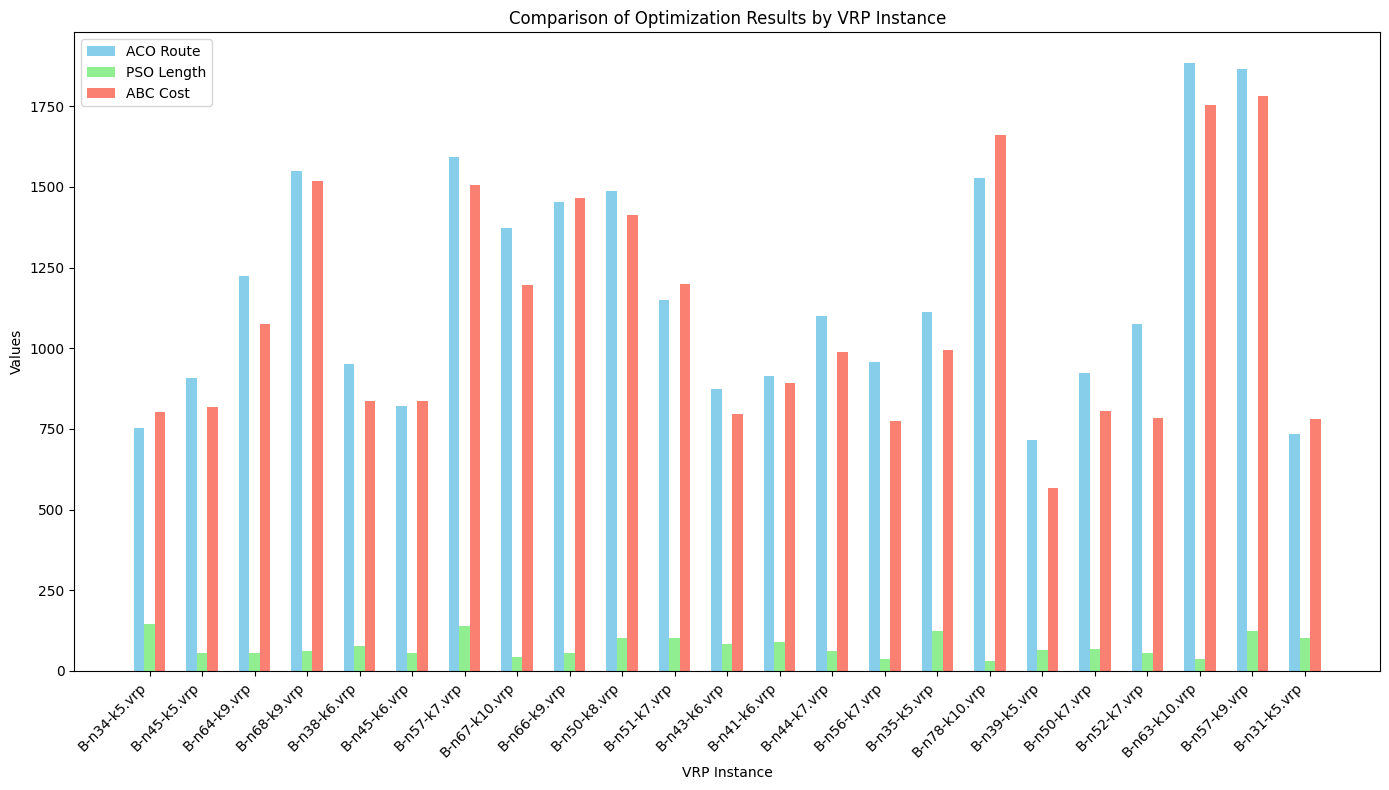

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming table_df is your DataFrame and it's correctly structured
vrp_instances = table_df['VRP Instance']
x = np.arange(len(vrp_instances))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width, table_df['ACO Route'], width, label='ACO Route', color='skyblue')
rects2 = ax.bar(x, table_df['PSO Length'], width, label='PSO Length', color='lightgreen')
rects3 = ax.bar(x + width, table_df['ABC Cost'], width, label='ABC Cost', color='salmon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('VRP Instance')
ax.set_ylabel('Values')
ax.set_title('Comparison of Optimization Results by VRP Instance')
ax.set_xticks(x)
ax.set_xticklabels(vrp_instances, rotation=45, ha="right")
ax.legend()


fig.tight_layout()

plt.show()
